# Importación de librerías

In [3]:
import pandas as pd
import numpy as np
import time 

import os
import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Lectura del dataset

In [5]:
urbansound8k_path = "../../data/raw/UrbanSound8K/"

# Primer dataset - Carpeta con los audios
urbansound8k_audio_path = "audio/"

# Segundo dataset - Archivo CSV con metadatos sobre los audios
urbansound8k_metadata_path_file = "metadata/UrbanSound8K.csv" 

# Dataset input
dataset_input_path = "../../data/processed/pd01_mfcc13.csv"


In [6]:
# Lectura
dataset_urbansound8k_df = pd.read_csv(dataset_input_path, sep=";")

dataset_urbansound8k_df.head(3)

,slice_file_name,fold,classID,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,...,delta2_mfcc_var_4,delta2_mfcc_var_5,delta2_mfcc_var_6,delta2_mfcc_var_7,delta2_mfcc_var_8,delta2_mfcc_var_9,delta2_mfcc_var_10,delta2_mfcc_var_11,delta2_mfcc_var_12,delta2_mfcc_var_13
0,100032-3-0-0.wav,5,3,-275.91843,119.49280,-98.21178,-66.515140,-42.606050,0.505066,-28.330938,...,116.963340,28.015196,153.756260,35.081203,40.550793,19.388300,49.317924,41.223183,27.885939,51.33420
1,100263-2-0-117.wav,5,2,-500.90840,185.10641,-86.53282,49.858850,9.230822,22.548956,-3.567175,...,30.765085,34.802017,35.170403,32.595600,35.089226,29.046677,31.543688,38.453808,28.922888,32.19454
2,100263-2-0-121.wav,5,2,-531.19530,186.93994,-70.34916,40.429245,9.121047,18.398588,6.283282,...,33.774395,34.858345,33.916622,30.953386,31.146223,27.312347,28.527649,25.948908,28.198223,31.85179


In [7]:
print("Columnas del dataset:")
print(dataset_urbansound8k_df.columns)
print("---")

print(f"Cantidad de columnas: {dataset_urbansound8k_df.shape[1]}")
print(f"Cantidad de filas: {dataset_urbansound8k_df.shape[0]}")

Columnas del dataset:
Index(['slice_file_name', 'fold', 'classID', 'mfcc_mean_1', 'mfcc_mean_2',
       'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6',
       'mfcc_mean_7',
       ...
       'delta2_mfcc_var_4', 'delta2_mfcc_var_5', 'delta2_mfcc_var_6',
       'delta2_mfcc_var_7', 'delta2_mfcc_var_8', 'delta2_mfcc_var_9',
       'delta2_mfcc_var_10', 'delta2_mfcc_var_11', 'delta2_mfcc_var_12',
       'delta2_mfcc_var_13'],
      dtype='object', length=146)
---
Cantidad de columnas: 146
Cantidad de filas: 8732


# Generación datos de entrenamiento y prueba

In [8]:
# Separar las características y la variable objetivo
# ['tasa_cruce_cero', 'entropia_espectograma', 'avg_centroide_espectral'
columnas_caracteristicas = [
    'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 
'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 
'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_median_1', 'mfcc_median_2', 
'mfcc_median_3', 'mfcc_median_4', 'mfcc_median_5', 'mfcc_median_6', 'mfcc_median_7', 
'mfcc_median_8', 'mfcc_median_9', 'mfcc_median_10', 'mfcc_median_11', 'mfcc_median_12', 
'mfcc_median_13', 'mfcc_min_1', 'mfcc_min_2', 'mfcc_min_3', 'mfcc_min_4', 
'mfcc_min_5', 'mfcc_min_6', 'mfcc_min_7', 'mfcc_min_8', 'mfcc_min_9', 
'mfcc_min_10', 'mfcc_min_11', 'mfcc_min_12', 'mfcc_min_13', 'mfcc_max_1', 
'mfcc_max_2', 'mfcc_max_3', 'mfcc_max_4', 'mfcc_max_5', 'mfcc_max_6', 
'mfcc_max_7', 'mfcc_max_8', 'mfcc_max_9', 'mfcc_max_10', 'mfcc_max_11', 
'mfcc_max_12', 'mfcc_max_13', 'mfcc_var_1', 'mfcc_var_2', 'mfcc_var_3', 
'mfcc_var_4', 'mfcc_var_5', 'mfcc_var_6', 'mfcc_var_7', 'mfcc_var_8', 
'mfcc_var_9', 'mfcc_var_10', 'mfcc_var_11', 'mfcc_var_12', 'mfcc_var_13', 
'mfcc_skew_1', 'mfcc_skew_2', 'mfcc_skew_3', 'mfcc_skew_4', 'mfcc_skew_5', 
'mfcc_skew_6', 'mfcc_skew_7', 'mfcc_skew_8', 'mfcc_skew_9', 'mfcc_skew_10', 
'mfcc_skew_11', 'mfcc_skew_12', 'mfcc_skew_13', 'mfcc_kurt_1', 'mfcc_kurt_2', 
'mfcc_kurt_3', 'mfcc_kurt_4', 'mfcc_kurt_5', 'mfcc_kurt_6', 'mfcc_kurt_7', 
'mfcc_kurt_8', 'mfcc_kurt_9', 'mfcc_kurt_10', 'mfcc_kurt_11', 'mfcc_kurt_12', 
'mfcc_kurt_13', 'delta_mfcc_mean_1', 'delta_mfcc_mean_2', 'delta_mfcc_mean_3', 'delta_mfcc_mean_4', 
'delta_mfcc_mean_5', 'delta_mfcc_mean_6', 'delta_mfcc_mean_7', 'delta_mfcc_mean_8', 'delta_mfcc_mean_9', 
'delta_mfcc_mean_10', 'delta_mfcc_mean_11', 'delta_mfcc_mean_12', 'delta_mfcc_mean_13', 'delta_mfcc_var_1', 
'delta_mfcc_var_2', 'delta_mfcc_var_3', 'delta_mfcc_var_4', 'delta_mfcc_var_5', 'delta_mfcc_var_6', 
'delta_mfcc_var_7', 'delta_mfcc_var_8', 'delta_mfcc_var_9', 'delta_mfcc_var_10', 'delta_mfcc_var_11', 
'delta_mfcc_var_12', 'delta_mfcc_var_13', 'delta2_mfcc_mean_1', 'delta2_mfcc_mean_2', 'delta2_mfcc_mean_3', 
'delta2_mfcc_mean_4', 'delta2_mfcc_mean_5', 'delta2_mfcc_mean_6', 'delta2_mfcc_mean_7', 'delta2_mfcc_mean_8', 
'delta2_mfcc_mean_9', 'delta2_mfcc_mean_10', 'delta2_mfcc_mean_11', 'delta2_mfcc_mean_12', 'delta2_mfcc_mean_13', 
'delta2_mfcc_var_1', 'delta2_mfcc_var_2', 'delta2_mfcc_var_3', 'delta2_mfcc_var_4', 'delta2_mfcc_var_5', 
'delta2_mfcc_var_6', 'delta2_mfcc_var_7', 'delta2_mfcc_var_8', 'delta2_mfcc_var_9', 'delta2_mfcc_var_10', 
'delta2_mfcc_var_11', 'delta2_mfcc_var_12', 'delta2_mfcc_var_13'
]

columna_predecir = 'classID'
columna_fold = 'fold'

# Separar las características y etiquetas
X_caracteristicas = dataset_urbansound8k_df[columnas_caracteristicas]  # 'classID' es la etiqueta y 'fold' el número de fold
y = dataset_urbansound8k_df[columna_predecir]
folds = dataset_urbansound8k_df['fold']

# Modelos de Clasificacion

In [7]:
# Iniciar el experimento en MLflow
mlflow.set_experiment("RSCV MFCC13 v1 - SVM")

2024/10/06 23:07:02 INFO mlflow.tracking.fluent: Experiment with name 'RSCV MFCC13 v1 - SVM' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/colbe/Documents/VIU/TFM/tfm-clasificador-fuentes-sonoras-ciudad/notebooks/modelado/mlruns/816287915961199959', creation_time=1728274022732, experiment_id='816287915961199959', last_update_time=1728274022732, lifecycle_stage='active', name='RSCV MFCC13 v1 - SVM', tags={}>

## KNeighborsClassifier

Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5813601076157597
Fold 1 Accuracy: 0.5097
Tiempo de entrenamiento (segundos): 14.0371


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5800604445599896
Fold 2 Accuracy: 0.5383
Tiempo de entrenamiento (segundos): 10.4941


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5917677862044058
Fold 3 Accuracy: 0.4703
Tiempo de entrenamiento (segundos): 12.8650


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5781447028423774
Fold 4 Accuracy: 0.5939
Tiempo de entrenamiento (segundos): 12.0879


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.563997070537507
Fold 5 Accuracy: 0.6400
Tiempo de entrenamiento (segundos): 11.9589


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'distance', 'n_neighbors': 27, 'metric': 'manhattan'}
Mejor Score: 0.5678205764214501
Fold 6 Accuracy: 0.5346
Tiempo de entrenamiento (segundos): 12.1627


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5833556336333445
Fold 7 Accuracy: 0.5119
Tiempo de entrenamiento (segundos): 12.7301


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5788471091749781
Fold 8 Accuracy: 0.5347
Tiempo de entrenamiento (segundos): 12.5690


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 5, 'metric': 'manhattan'}
Mejor Score: 0.5602454698693637
Fold 9 Accuracy: 0.6373
Tiempo de entrenamiento (segundos): 12.5422


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
Mejor Score: 0.5699691967078981
Fold 10 Accuracy: 0.5806
Tiempo de entrenamiento (segundos): 12.5369


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.5551
Desviación estándar: 0.0532


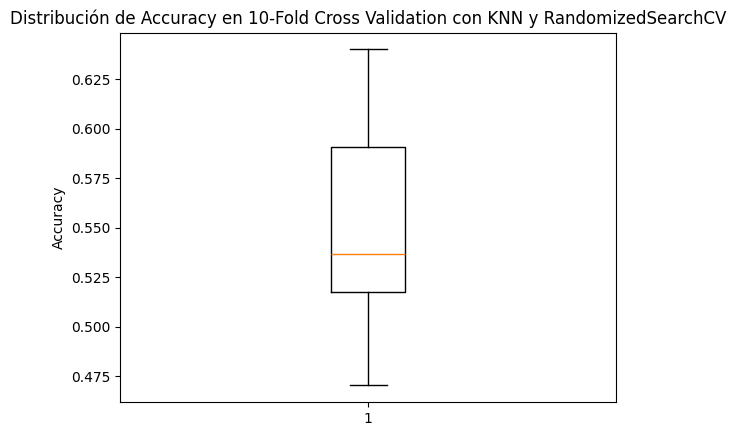

In [15]:
# Definir el modelo KNN
knn = KNeighborsClassifier()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_neighbors': np.arange(1, 31),  # Número de vecinos a considerar
    'weights': ['uniform', 'distance'],  # Función de peso a usar
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métrica de distancia
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K

    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=knn, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_knn = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_    
    
    # Predecir y evaluar
    y_pred = best_knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    
    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")        
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"KNN RSCV MFCC13 Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        # Registrar la métrica de accuracy de este fold
        mlflow.log_metric(f"accuracy_score", accuracy)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_knn, f"knn_rscv_mfcc10_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")


# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con KNN y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()


## Random Forest

Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7052866242038218
Fold 1 Accuracy: 0.6838
Tiempo de entrenamiento (segundos): 466.2548


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7125128363447291
Fold 2 Accuracy: 0.6622
Tiempo de entrenamiento (segundos): 465.3384


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.7110123444630487
Fold 3 Accuracy: 0.5546
Tiempo de entrenamiento (segundos): 460.1066


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.7008535467200133
Fold 4 Accuracy: 0.7010
Tiempo de entrenamiento (segundos): 461.1525


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.6776322372535466
Fold 5 Accuracy: 0.7051
Tiempo de entrenamiento (segundos): 465.8653


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.6960257005232922
Fold 6 Accuracy: 0.6865
Tiempo de entrenamiento (segundos): 467.7664


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.6929219810367233
Fold 7 Accuracy: 0.6921
Tiempo de entrenamiento (segundos): 469.1944


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Mejor Score: 0.6965541289311782
Fold 8 Accuracy: 0.6687
Tiempo de entrenamiento (segundos): 473.0198


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.691481662388742
Fold 9 Accuracy: 0.7071
Tiempo de entrenamiento (segundos): 466.7806


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


Mejores Parámetros: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Mejor Score: 0.704602204360591
Fold 10 Accuracy: 0.7431
Tiempo de entrenamiento (segundos): 465.0656


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.6804
Desviación estándar: 0.0471
Tiempo de entrenamiento promedio (segundos): 466.0544


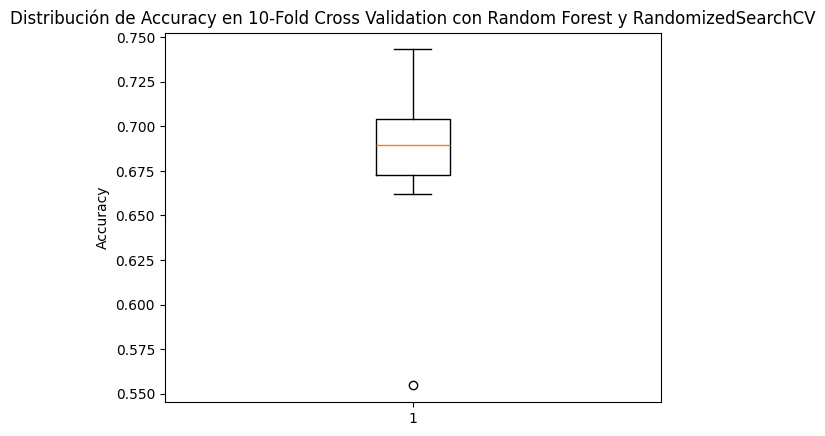

In [16]:
# Definir el modelo Random Forest
rf = RandomForestClassifier(random_state=42)

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 500],  # Número de árboles en el bosque
    'max_depth': [None, 10, 20, 30, 40, 50],  # Máxima profundidad de cada árbol
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras requeridas en una hoja
    'max_features': ['sqrt', 'log2'],  # Número de características a considerar al buscar la mejor división
    'bootstrap': [True, False]  # Método para seleccionar muestras para construir cada árbol
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf, 
        param_distributions=param_distributions, 
        n_iter=10,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna con 10 pliegues
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_rf = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"RandomForest RSCV MFCC13 Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        # Registrar la métrica de accuracy de este fold
        mlflow.log_metric(f"accuracy_score", accuracy)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_rf, f"rf_rscv_mfcc13_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con Random Forest y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()

## SVM

iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.664578045736698
Fold 1 Accuracy: 0.6220
Tiempo de entrenamiento (segundos): 2320.3117


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6715743208111269
Fold 2 Accuracy: 0.5890
Tiempo de entrenamiento (segundos): 1942.2721


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6802542762401916
Fold 3 Accuracy: 0.5654
Tiempo de entrenamiento (segundos): 2030.0542


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.659502042177211
Fold 4 Accuracy: 0.6202
Tiempo de entrenamiento (segundos): 1781.1192


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6500472334682861
Fold 5 Accuracy: 0.6656
Tiempo de entrenamiento (segundos): 2156.7655


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6562044519835493
Fold 6 Accuracy: 0.6707
Tiempo de entrenamiento (segundos): 2156.9573


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6523644735364426
Fold 7 Accuracy: 0.6850
Tiempo de entrenamiento (segundos): 2047.6658


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6589506349752251
Fold 8 Accuracy: 0.6687
Tiempo de entrenamiento (segundos): 2069.2762


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.6673554444572144
Fold 9 Accuracy: 0.6936
Tiempo de entrenamiento (segundos): 1966.9181


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


iniciando
Mejores Parámetros: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.656595434053681
Fold 10 Accuracy: 0.6284
Tiempo de entrenamiento (segundos): 2116.9387


c:\Users\colbe\Documents\VIU\TFM\tfm-clasificador-fuentes-sonoras-ciudad\.env\lib\site-packages\mlflow\types\utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(



Accuracy promedio: 0.6409
Desviación estándar: 0.0404
Tiempo de entrenamiento promedio (segundos): 2058.8279


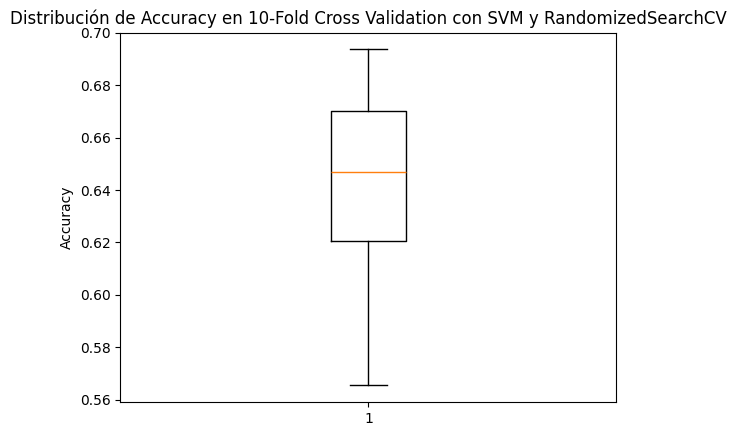

In [11]:
# Definir el modelo SVM
svm = SVC()

# Definir la rejilla de parámetros para RandomizedSearchCV
param_distributions = {
    'C': [0.001, 0.0001],  # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Coeficiente del kernel 'rbf', 'poly' o 'sigmoid' 
}

# Inicializar lista para almacenar accuracies y tiempos
fold_accuracies = []
fold_training_times = []  # Lista para almacenar los tiempos de entrenamiento

# Realizar la validación cruzada respetando los folds predefinidos
for fold in range(1, 11):  # Hay 10 folds en UrbanSound8K
    # Dividir el dataset en entrenamiento y prueba
    train_index = folds != fold
    test_index = folds == fold
    
    X_train, X_test = X_caracteristicas[train_index], X_caracteristicas[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("iniciando")

    # Configurar RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=svm, 
        param_distributions=param_distributions, 
        n_iter=5,  # Número de combinaciones aleatorias a probar
        cv=10,  # Validación cruzada interna 
        scoring='accuracy',  # Métrica para optimizar
        n_jobs=-1,  # Usar todos los núcleos disponibles
        random_state=42
    )

    # Medir el tiempo de entrenamiento
    start_time = time.time()  # Inicio del tiempo

    # Entrenar el modelo con la búsqueda de hiperparámetros
    random_search.fit(X_train, y_train)

    # Tiempo de finalización
    end_time = time.time()

    # Calcular el tiempo de entrenamiento
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    # Obtener el mejor modelo
    best_svm = random_search.best_estimator_

    # Obtener los mejores parámetros y el mejor score
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Predecir y evaluar
    y_pred = best_svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print(f"Mejores Parámetros: {best_params}")
    print(f"Mejor Score: {best_score}")
    print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    print(f"Tiempo de entrenamiento (segundos): {training_time:.4f}")

    with mlflow.start_run(run_name=f"SVM RSCV MFCC13 Fold_{fold}") as run:
        # Registrar los parámetros y métricas en MLflow
        mlflow.log_params(best_params)

        # Registrar la métrica de accuracy de este fold
        mlflow.log_metric(f"accuracy_score", accuracy)

        # Registrar el tiempo de entrenamiento
        mlflow.log_metric(f"training_time_seconds", training_time)

        # Guardar el modelo en MLflow con un ejemplo de entrada
        input_example = X_test[:1]  # Ejemplo de entrada, una sola muestra de prueba
        mlflow.sklearn.log_model(best_svm, f"svm_rscv_mfcc13_fold_{fold}", input_example=input_example)

        # Se finaliza el registro
        mlflow.end_run()


# Mostrar el promedio y desviación estándar
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_training_time = np.mean(fold_training_times)

print(f"\nAccuracy promedio: {mean_accuracy:.4f}")
print(f"Desviación estándar: {std_accuracy:.4f}")
print(f"Tiempo de entrenamiento promedio (segundos): {mean_training_time:.4f}")

# Opcional: Visualizar los resultados con un boxplot
plt.boxplot(fold_accuracies)
plt.title('Distribución de Accuracy en 10-Fold Cross Validation con SVM y RandomizedSearchCV')
plt.ylabel('Accuracy')
plt.show()
